# 🌎 Welcome to the CSE151B Spring 2025 Climate Emulation Competition!

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help you:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


### 📦 Install Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [1]:
%pip install xarray zarr dask lightning matplotlib wandb cftime einops vizarr


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of numcodecs[crc32c] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 114.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5 kB 66.8 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=ff3163b54d4db3cb888e1eb4cbac0be500480916b6f872afb3d84be31dff5b52
  Stored in directory: /home/mpodgore/.cache/pip/wheels/71/c1/da/23077eb3b87d24d6f3852ed1ed1a1ac2d3c885ad6ebd2b4a07
Successfully built asciitree
  Attempting uninstall: numcodecs
    Found existing installation: numcodecs 0.16.0
    Uninstal

In [25]:
# lets visuzlize a zarr file
import vizarr
import zarr

In [68]:

import os
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
from lightning.pytorch.callbacks import EarlyStopping

### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [69]:
early_stopping = EarlyStopping(
    monitor='val/pr/rmse',  # You'll need to calculate and log val_rmse in your LightningModule
    min_delta=0.001,       # Minimum change in the monitored quantity to qualify as an improvement.
    patience=5,          # Stop after 5 epochs of no improvement
    verbose=True,
    mode='min'           # Assuming lower RMSE is better
)

In [70]:
config = {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["pr"],  # MODIFIED
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 16,
        "num_workers": 0,
    },
    "model": {
        "type": "u_vit",
        "img_size_h": 48,
        "img_size_w": 72,
        "in_channels": 5,
        "out_channels": 1,  # MODIFIED
        "patch_size": 8,
        "hidden_size": 768,
        "num_heads": 12,
        "num_encoder_layers": 8,
        "mlp_ratio": 4.0,
        "dropout_rate": 0.1,
        "attention_dropout_rate": 0.1,
        "decoder_init_features": 128,
        "bilinear": True,
    },
    "training": {
        "lr": 1e-4,
    },
    "trainer": {
        "max_epochs": 40,
        "accelerator": "auto",
        "devices": "auto",
        "precision": 16,
        "deterministic": True,
        "num_sanity_val_steps": 0,
        "callbacks": [] # Callbacks will be appended later if needed
    },
    "seed": 42,
}


pl.seed_everything(config["seed"])

Seed set to 42


42

In [71]:
config["trainer"]["callbacks"].append(early_stopping)

### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [72]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**. 

We encourage you to build and experiment with your own models and ideas.


In [73]:
ds = xr.open_zarr(config["data"]["path"], consolidated=False, chunks={"time": 24})
# Add this line to print the number of member IDs
if 'member_id' in ds.coords:
    num_members = len(ds.coords['member_id'].values)
    print(f"Number of ensemble members: {num_members}")
else:
    print("The 'member_id' coordinate was not found in the dataset.")

Number of ensemble members: 3


In [74]:
import torch
import torch.nn as nn
import lightning.pytorch as pl # Changed from import lightning as pl for modern PyTorch Lightning

# --- Helper Modules (PatchEmbed, Attention, Mlp, Block are assumed to be the same as in the notebook) ---
class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding.
    Converts input images into a sequence of flattened patches, then projects them to a hidden dimension.
    """
    def __init__(self, img_size_h, img_size_w, patch_size, in_channels, hidden_size):
        super().__init__()
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.num_patches_h = img_size_h // patch_size
        self.num_patches_w = img_size_w // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        self.proj = nn.Conv2d(in_channels, hidden_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size_h and W == self.img_size_w, \
            f"Input image size ({H}x{W}) doesn't match model ({self.img_size_h}x{self.img_size_w})."

        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2) # (B, num_patches, hidden_size)
        return x

class Attention(nn.Module):
    """
    Multi-head Self-Attention module.
    """
    def __init__(self, hidden_size, num_heads, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = hidden_size // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(hidden_size, hidden_size * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(hidden_size, hidden_size)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Mlp(nn.Module):
    """
    Multi-layer Perceptron (Feed-forward network).
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Block(nn.Module):
    """
    Transformer Encoder Block.
    """
    def __init__(self, hidden_size, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(hidden_size)
        self.attn = Attention(hidden_size, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = norm_layer(hidden_size)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


# --- SimpleViTRegressor Model Implementation ---

class SimpleViTRegressor(pl.LightningModule):
    """
    A simple Vision Transformer for image-to-image regression.
    It uses a ViT encoder followed by a minimal upsampling head to reconstruct the output.
    """
    def __init__(self,
                 img_size_h, img_size_w, patch_size, in_channels, out_channels,
                 hidden_size, num_heads, num_encoder_layers, mlp_ratio,
                 dropout_rate, attention_dropout_rate,
                 decoder_init_features, bilinear): # decoder_init_features and bilinear are used for the upsampling head
        super().__init__()
        # It's good practice to save hyperparameters if you might need them later (e.g. for logging or loading)
        # self.save_hyperparameters() # Uncomment if you want all these to be in self.hparams

        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_size = hidden_size
        self.decoder_init_features = decoder_init_features # Store for use
        self.bilinear = bilinear # Store for use

        # Calculate number of patches
        self.num_patches_h = img_size_h // patch_size
        self.num_patches_w = img_size_w // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w

        # --- ViT Encoder ---
        self.patch_embed = PatchEmbed(
            img_size_h=img_size_h, img_size_w=img_size_w, patch_size=patch_size,
            in_channels=in_channels, hidden_size=hidden_size
        )

        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, hidden_size))
        self.pos_drop = nn.Dropout(p=dropout_rate)

        self.blocks = nn.ModuleList([
            Block(
                hidden_size=hidden_size,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=True, # qkv_bias is often set to True in ViT
                drop=dropout_rate,
                attn_drop=attention_dropout_rate
            )
            for _ in range(num_encoder_layers)
        ])
        self.norm = nn.LayerNorm(hidden_size)

        # --- Upsampling Head ---
        self.head_conv_in = nn.Conv2d(hidden_size, self.decoder_init_features * 4, kernel_size=1)

        features = self.decoder_init_features * 4 # This variable will track the number of channels

        # Define a simple ConvBlock for the upsampling head
        # Moved ConvBlock definition inside __init__ or ensure it's accessible
        # For simplicity, defining it here. In a larger project, it might be a separate class.
        class ConvBlock(nn.Module):
            def __init__(self, in_ch, out_ch):
                super().__init__()
                self.conv = nn.Sequential(
                    nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False), # Bias is often false if BatchNorm follows
                    nn.BatchNorm2d(out_ch),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(out_ch),
                    nn.ReLU(inplace=True)
                )
            def forward(self, x):
                return self.conv(x)

        # Upsampling step 1
        if self.bilinear:
            self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv1 = ConvBlock(features, features // 2)
        else:
            self.up1 = nn.ConvTranspose2d(features, features // 2, kernel_size=2, stride=2)
            self.conv1 = ConvBlock(features // 2, features // 2)
        features //= 2

        # Upsampling step 2
        if self.bilinear:
            self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv2 = ConvBlock(features, features // 2)
        else:
            self.up2 = nn.ConvTranspose2d(features, features // 2, kernel_size=2, stride=2)
            self.conv2 = ConvBlock(features // 2, features // 2)
        features //= 2

        # Upsampling step 3
        if self.bilinear:
            self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv3 = ConvBlock(features, features // 2)
        else:
            self.up3 = nn.ConvTranspose2d(features, features // 2, kernel_size=2, stride=2)
            self.conv3 = ConvBlock(features // 2, features // 2)
        features //= 2

        # Final output convolution to map to out_channels
        self.out_conv = nn.Conv2d(features, self.out_channels, kernel_size=1)


    def forward(self, x):
        # x: (B, C_in, H, W) e.g., (16, 5, 48, 72)

        # 1. Patch Embedding
        x_patches = self.patch_embed(x) # (B, num_patches, hidden_size)

        # 2. Add Positional Embedding
        x_patches = x_patches + self.pos_embed
        x_patches = self.pos_drop(x_patches)

        # 3. Transformer Encoder
        for blk in self.blocks:
            x_patches = blk(x_patches)
        x_patches = self.norm(x_patches) # (B, num_patches, hidden_size)

        # 4. Reshape ViT output to spatial feature map
        # (B, num_patches, hidden_size) -> (B, hidden_size, num_patches_h, num_patches_w)
        B, N, C = x_patches.shape
        x_spatial = x_patches.permute(0, 2, 1).reshape(B, C, self.num_patches_h, self.num_patches_w)

        # 5. Upsampling Head
        x_out = self.head_conv_in(x_spatial) # Channels: decoder_init_features * 4

        x_out = self.up1(x_out)
        x_out = self.conv1(x_out) # Channels: (decoder_init_features * 4) // 2

        x_out = self.up2(x_out)
        x_out = self.conv2(x_out) # Channels: (decoder_init_features * 4) // 4

        x_out = self.up3(x_out)
        x_out = self.conv3(x_out) # Channels: (decoder_init_features * 4) // 8

        final_output = self.out_conv(x_out) # (B, C_out, H, W)
        return final_output

### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [75]:
class Normalizer:
    def __init__(self, log_transform_input=False, log_transform_output=False):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None
        self.log_transform_input = log_transform_input
        self.log_transform_output = log_transform_output
        self.epsilon = 1e-10  # small constant to avoid log(0)

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            if self.log_transform_input:
                data = np.log(data + self.epsilon)
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            if self.log_transform_output:
                data = np.log(data + self.epsilon)
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        denormalized = data * self.std_out + self.mean_out
        if self.log_transform_output:
            return np.exp(denormalized) - self.epsilon
        return denormalized

    def inverse_transform_input(self, data):
        denormalized = data * self.std_in + self.mean_in
        if self.log_transform_input:
            return np.exp(denormalized) - self.epsilon
        return denormalized

### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


In [76]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        # target_member_id, # This is no longer needed if we're averaging all members
        val_split=0.1,
        test_months=360,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        # self.target_member_id = target_member_id # Remove this line
        self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer(log_transform_output=True)

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    # For input variables, you might still want to select a specific member or average.
                    # For this example, we'll keep the original behavior for inputs to use target_member_id if it exists.
                    # If you also want to average input members, you'd apply .mean('member_id') here.
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp)
                if "member_id" in da_out.dims:
                    # This is the key change: take the mean across the 'member_id' dimension
                    da_out = da_out.mean('member_id') 
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask.append(da_out.data)

            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)

        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        # train_input_norm = train_input
        # train_output_norm = train_output
        # val_input_norm = val_input
        # val_output_norm = val_output
        

        test_input, test_output = load_ssp(self.test_ssp)
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        test_input_norm = self.normalizer.normalize(test_input, "input")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        self.test_dataset = ClimateDataset(test_input_norm, test_output, output_is_normalized=False)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

In [77]:
cdm = ClimateDataModule(
    path=config["data"]["path"],
        input_vars=config["data"]["input_vars"],
        output_vars=config["data"]["output_vars"],
        train_ssps=config["data"]["train_ssps"],
        test_ssp=config["data"]["test_ssp"],
        test_months=config["data"]["test_months"],
        batch_size=config["data"]["batch_size"],
        num_workers=config["data"]["num_workers"],
        seed=config["seed"],
)
cdm.prepare_data()
cdm.setup()
# print the shape of train, validation, and test datasets
print(f"Train dataset shape: {len(cdm.train_dataset)}, {cdm.train_dataset.outputs.shape}")
print(f"Validation dataset shape: {cdm.val_dataset.inputs.shape}, {cdm.val_dataset.outputs.shape}")
print(f"Test dataset shape: {cdm.test_dataset.inputs.shape}, {cdm.test_dataset.outputs.shape}")



Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...
Train dataset shape: 2703, torch.Size([2703, 1, 48, 72])
Validation dataset shape: torch.Size([360, 5, 48, 72]), torch.Size([360, 1, 48, 72])
Test dataset shape: torch.Size([360, 5, 48, 72]), torch.Size([360, 1, 48, 72])


# Lets visualize the distribution of output variables

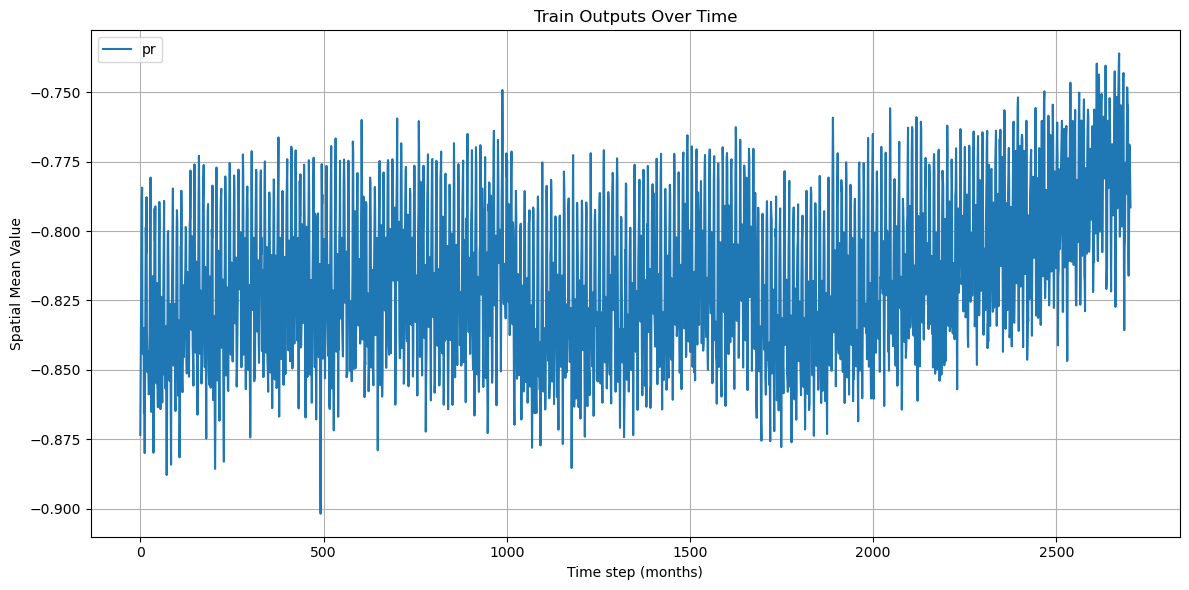

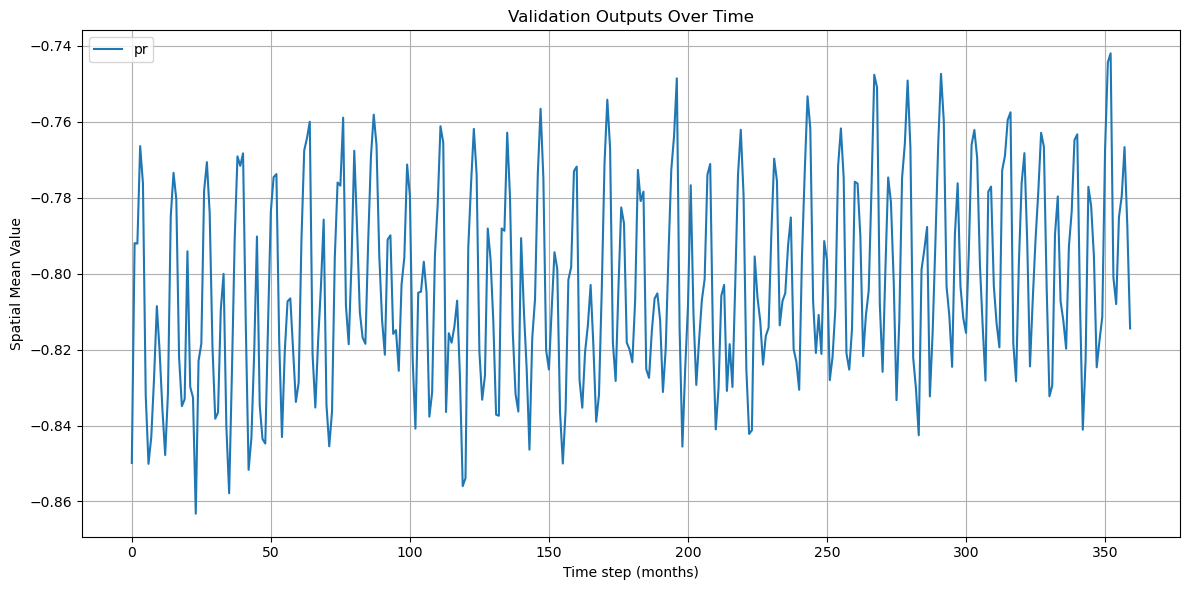

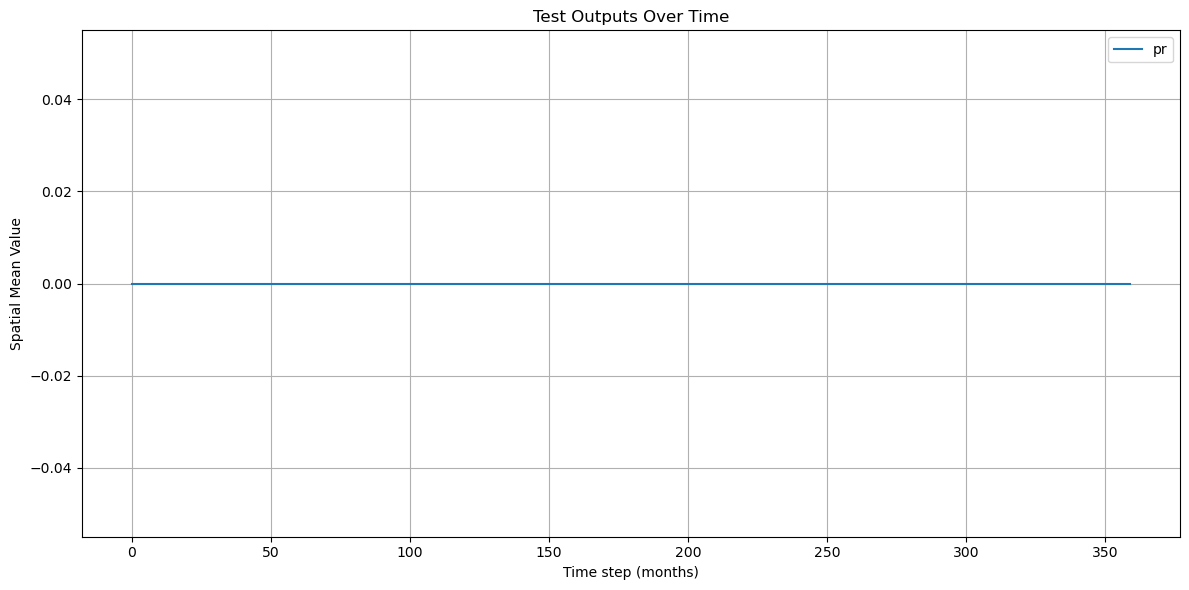

In [78]:
import matplotlib.pyplot as plt
import torch

def plot_output_over_time(outputs, output_var_names, title_prefix="Train"):
    """
    Plot the spatial average of each output variable over time.
    
    Args:
        outputs (torch.Tensor): shape [T, C, H, W]
        output_var_names (list): Names of output variables, length C
        title_prefix (str): "Train", "Val", or "Test"
    """
    if outputs.dim() != 4:
        raise ValueError("Expected outputs with shape [T, C, H, W]")
    
    T, C, H, W = outputs.shape
    outputs_np = outputs.numpy()

    # Compute spatial average (mean over H and W) for each time step and variable
    spatial_means = outputs_np.mean(axis=(2, 3))  # shape: [T, C]

    # Plot each output variable's mean over time
    plt.figure(figsize=(12, 6))
    for i in range(C):
        plt.plot(spatial_means[:, i], label=output_var_names[i])
    
    plt.xlabel("Time step (months)")
    plt.ylabel("Spatial Mean Value")
    plt.title(f"{title_prefix} Outputs Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_output_over_time(cdm.train_dataset.outputs, cdm.output_vars, title_prefix="Train")
plot_output_over_time(cdm.val_dataset.outputs, cdm.output_vars, title_prefix="Validation")
plot_output_over_time(cdm.test_dataset.outputs, cdm.output_vars, title_prefix="Test")

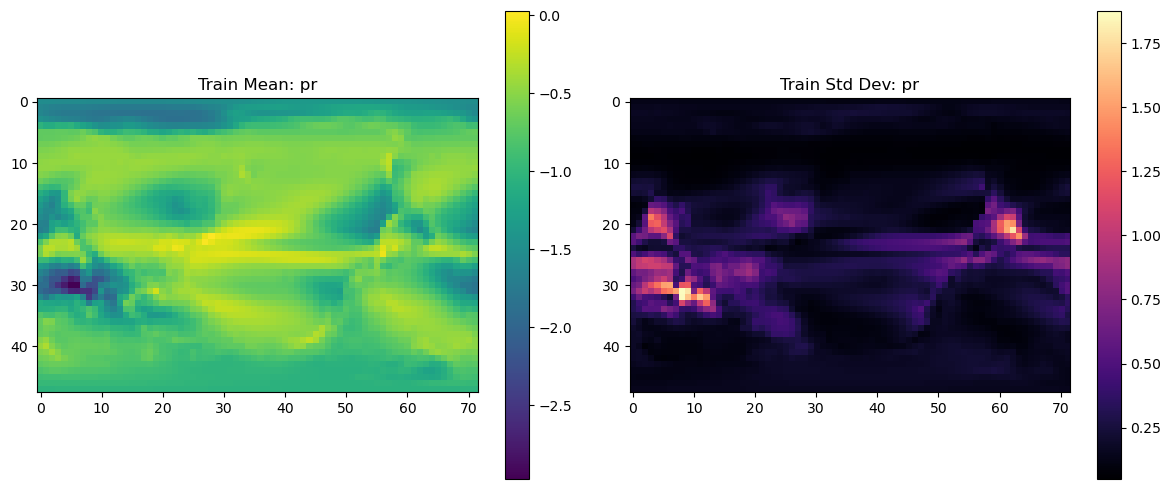

In [79]:
import matplotlib.pyplot as plt
import torch

def plot_spatial_stats(outputs, output_var_names, title_prefix="Train"):
    """
    Plot spatial mean and standard deviation maps for each output variable.

    Args:
        outputs (torch.Tensor): shape [T, C, H, W]
        output_var_names (list): Names of output variables
        title_prefix (str): e.g., "Train", "Validation", "Test"
    """
    if outputs.dim() != 4:
        raise ValueError("Expected outputs with shape [T, C, H, W]")

    T, C, H, W = outputs.shape
    outputs_np = outputs.numpy()

    spatial_mean = outputs_np.mean(axis=0)  # shape: [C, H, W]
    spatial_std = outputs_np.std(axis=0)    # shape: [C, H, W]

    for i in range(C):
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        
        im0 = axs[0].imshow(spatial_mean[i], cmap='viridis')
        axs[0].set_title(f"{title_prefix} Mean: {output_var_names[i]}")
        plt.colorbar(im0, ax=axs[0])

        im1 = axs[1].imshow(spatial_std[i], cmap='magma')
        axs[1].set_title(f"{title_prefix} Std Dev: {output_var_names[i]}")
        plt.colorbar(im1, ax=axs[1])

        plt.tight_layout()
        plt.show()

# Example usage:
plot_spatial_stats(cdm.train_dataset.outputs, cdm.output_vars, title_prefix="Train")


In [80]:
out_vars = cdm.output_vars
in_vars = cdm.input_vars
print(f"Input variables: {in_vars}")
print(f"Output variables: {out_vars}")

Input variables: ['CO2', 'SO2', 'CH4', 'BC', 'rsdt']
Output variables: ['pr']


In [81]:
train_output = cdm.train_dataset.outputs
print(f"Train output shape: {train_output.shape}")

Train output shape: torch.Size([2703, 1, 48, 72])


In [82]:
train_input = cdm.train_dataset.inputs
print(f"Train input shape: {train_input.shape}")

Train input shape: torch.Size([2703, 5, 48, 72])


In [83]:
print(in_vars)
train_input = cdm.train_dataset.inputs
train_input.shape

['CO2', 'SO2', 'CH4', 'BC', 'rsdt']


torch.Size([2703, 5, 48, 72])

## Here i used ai to write a loop to generate heatmaps

### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [84]:
import pandas as pd

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model']) # Save all hyperparameters except the model to self.hparams.<param_name>
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer  # Get the normalizer from the datamodule (see above)

    def training_step(self, batch, batch_idx):
        x, y = batch # Unpack inputs and targets (this is the output of the _getitem_ method in the Dataset above)
        y_hat = self(x)   # Forward pass
        loss = self.criterion(y_hat, y)  # Calculate loss
        self.log("train/loss", loss)  # Log loss for tracking
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)

        return loss

    def on_validation_epoch_end(self):
        # Concatenate all predictions and ground truths from each val step/batch into one array
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        # Concatenate all predictions and ground truths from each test step/batch into one array
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [85]:
model = SimpleViTRegressor(
        img_size_h=config["model"]["img_size_h"],
        img_size_w=config["model"]["img_size_w"],
        patch_size=config["model"]["patch_size"],
        in_channels=config["model"]["in_channels"],
        out_channels=config["model"]["out_channels"],
        hidden_size=config["model"]["hidden_size"],
        num_heads=config["model"]["num_heads"],
        num_encoder_layers=config["model"]["num_encoder_layers"],
        mlp_ratio=config["model"]["mlp_ratio"],
        dropout_rate=config["model"]["dropout_rate"],
        attention_dropout_rate=config["model"]["attention_dropout_rate"],
        decoder_init_features=config["model"]["decoder_init_features"],
        bilinear=config["model"]["bilinear"],
    )
climate_model = ClimateEmulationModule(
    model=model,
    learning_rate=config["training"]["lr"],
)

trainer = pl.Trainer(
        max_epochs=config["trainer"]["max_epochs"],
        accelerator=config["trainer"]["accelerator"],
        devices=config["trainer"]["devices"],
        precision=config["trainer"]["precision"],
        deterministic=config["trainer"]["deterministic"],
        num_sanity_val_steps=config["trainer"]["num_sanity_val_steps"],
        callbacks=config["trainer"]["callbacks"],
        # logger=logger, # Uncomment if you set up a logger
    )



/home/dpachchigar/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# Train the model
print("Starting training...")
trainer.fit(climate_model, cdm)
print("Training finished.")

Starting training...


In [65]:
trainer.test(climate_model, datamodule=cdm) 

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dpachchigar/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] pr: RMSE=2.3780, Time-Mean RMSE=2.2034, Time-Stddev MAE=0.7069
✅ Submission saved to: submissions/kaggle_submission_20250522_073734.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │    2.3780195713043213     │
│  test/pr/time_mean_rmse   │    2.2034249305725098     │
│   test/pr/time_std_mae    │    0.7069405913352966     │
└───────────────────────────┴───────────────────────────┘

[{'test/pr/rmse': 2.3780195713043213,
  'test/pr/time_mean_rmse': 2.2034249305725098,
  'test/pr/time_std_mae': 0.7069405913352966}]

# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

### Plotting Utils


In [56]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


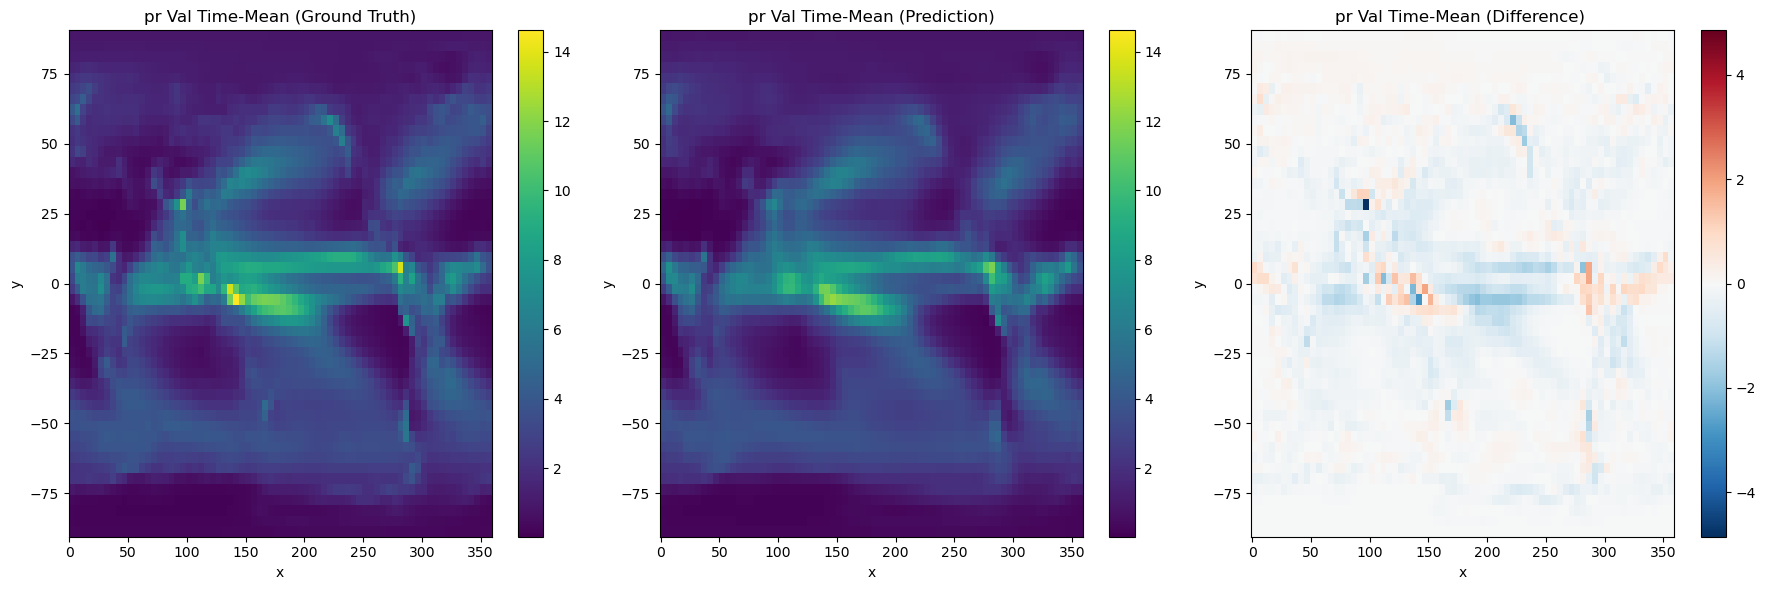

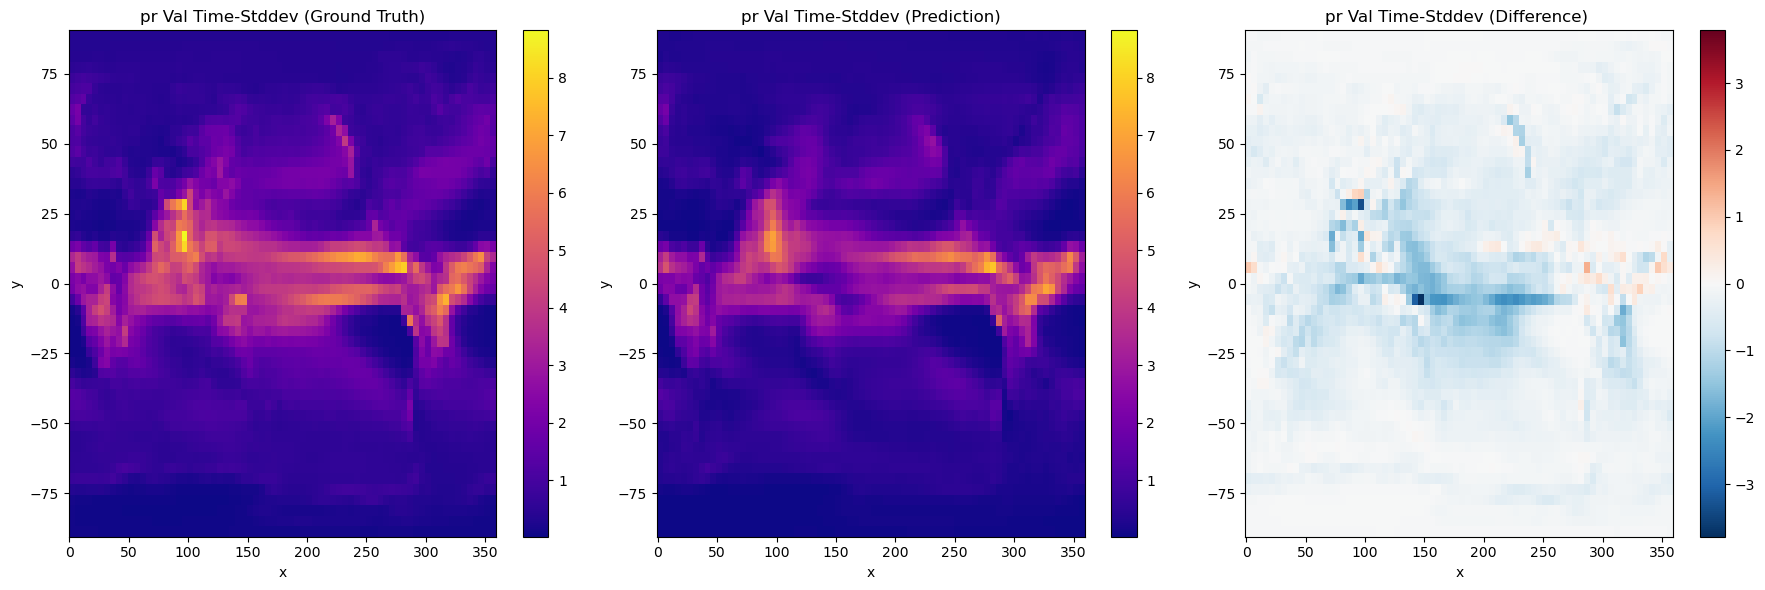

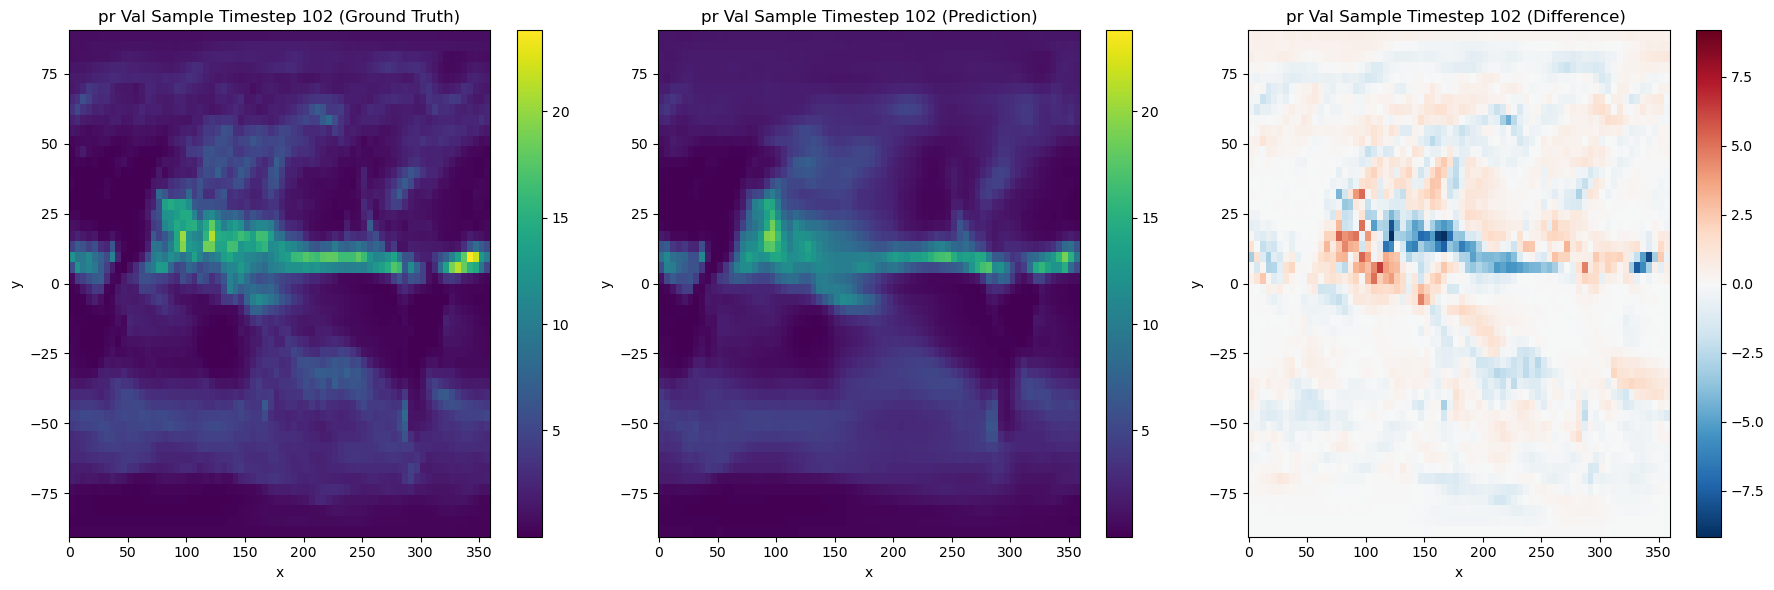

In [58]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = cdm.get_coords()
output_vars = cdm.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


In [ ]:
## Training Vs. Validation Loss

In [59]:

train_losses = trainer.model.training_loss  # List of batch losses
val_losses = trainer.model.val_loss          # List of validation batch losses

plt.plot(train_losses, label='Training Loss (per batch)')
plt.plot(val_losses, label='Validation Loss (per batch)')
plt.xlabel('Batch Index')
plt.ylabel('Loss')
plt.legend()
plt.show()


AttributeError: 'ClimateEmulationModule' object has no attribute 'training_loss'

## 🧪 Final Notes

This notebook is meant to serve as a **baseline template** — a starting point to help you get up and running quickly with the climate emulation challenge.

You are **not** required to stick to this exact setup. In fact, we **encourage** you to:

- 🔁 Build on top of the provided `DataModule`. 
- 🧠 Use your own model architectures or training pipelines that you’re more comfortable with 
- ⚗️ Experiment with ideas  
- 🥇 Compete creatively to climb the Kaggle leaderboard  
- 🙌 Most importantly: **have fun** and **learn as much as you can** along the way

This challenge simulates a real-world scientific problem, and there’s no single "correct" approach — so be curious, experiment boldly, and make it your own!


In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'climate_model' is your trained ClimateEmulationModule instance
# and 'cdm' is your ClimateDataModule instance.

# These lists contain per-batch losses accumulated during training
training_batch_losses = cdm.training_loss
validation_batch_losses = cdm.val_loss

# Get the number of batches per epoch from your dataloaders
# This is important for correctly averaging per epoch
num_train_batches_per_epoch = len(cdm.train_dataloader())
num_val_batches_per_epoch = len(cdm.val_dataloader())

# Calculate average training loss per epoch
avg_train_loss_per_epoch = []
if num_train_batches_per_epoch > 0:
    num_train_epochs_completed = len(training_batch_losses) // num_train_batches_per_epoch
    for i in range(num_train_epochs_completed):
        start_idx = i * num_train_batches_per_epoch
        end_idx = start_idx + num_train_batches_per_epoch
        epoch_train_losses = training_batch_losses[start_idx:end_idx]
        if epoch_train_losses: # Make sure there are losses to average
            avg_train_loss_per_epoch.append(np.mean(epoch_train_losses))

# Calculate average validation loss per epoch
avg_val_loss_per_epoch = []
if num_val_batches_per_epoch > 0:
    num_val_epochs_completed = len(validation_batch_losses) // num_val_batches_per_epoch
    for i in range(num_val_epochs_completed):
        start_idx = i * num_val_batches_per_epoch
        end_idx = start_idx + num_val_batches_per_epoch
        epoch_val_losses = validation_batch_losses[start_idx:end_idx]
        if epoch_val_losses: # Make sure there are losses to average
            avg_val_loss_per_epoch.append(np.mean(epoch_val_losses))

# Create epoch arrays for plotting
epochs_train = np.arange(1, len(avg_train_loss_per_epoch) + 1)
epochs_val = np.arange(1, len(avg_val_loss_per_epoch) + 1)

# Plotting
plt.figure(figsize=(10, 6))
if avg_train_loss_per_epoch:
    plt.plot(epochs_train, avg_train_loss_per_epoch, 'o-', label='Average Training Loss per Epoch')
else:
    print("No average training loss data to plot.")

if avg_val_loss_per_epoch:
    plt.plot(epochs_val, avg_val_loss_per_epoch, 'o-', label='Average Validation Loss per Epoch')
else:
    print("No average validation loss data to plot. This might happen if validation_batch_losses was empty or num_val_batches_per_epoch was zero.")


plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
# Ensure integer ticks for epochs if data is available
if len(epochs_train) > 0 or len(epochs_val) > 0:
    max_epoch = max(len(epochs_train), len(epochs_val))
    if max_epoch > 0 :
        plt.xticks(np.arange(1, max_epoch + 1, step=max(1, max_epoch // 10))) # Adjust step for readability

plt.show()

# As a sanity check, print the number of epochs for which data was found
print(f"Number of epochs for average training loss: {len(avg_train_loss_per_epoch)}")
print(f"Number of epochs for average validation loss: {len(avg_val_loss_per_epoch)}")
print(f"Total training batches recorded: {len(training_batch_losses)}")
print(f"Total validation batches recorded: {len(validation_batch_losses)}")
if hasattr(trainer, 'current_epoch'):
    print(f"Trainer current epoch (0-indexed for last completed, so +1 for count): {trainer.current_epoch +1 }")

AttributeError: 'ClimateDataModule' object has no attribute 'training_loss'